# Graph Learning
## Lab 6: Spectral Embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [36]:
from IPython.display import SVG

In [37]:
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt

In [38]:
!pip install scikit-network

In [39]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [40]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [41]:
dataset = karate_club(metadata=True)

In [42]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

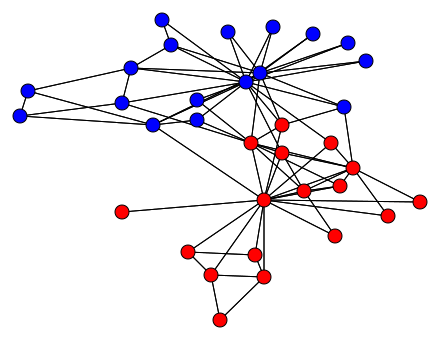

In [43]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues).
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first component of the embedding to the ground-truth clusters.

In [44]:
spectral = Spectral(20, normalized=False)

In [45]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

In [46]:
# eigenvalues (adding the first)
eigenvalues = [1] + list(spectral.eigenvalues_)

In [47]:
# eigenvectors
eigenvectors = spectral.eigenvectors_

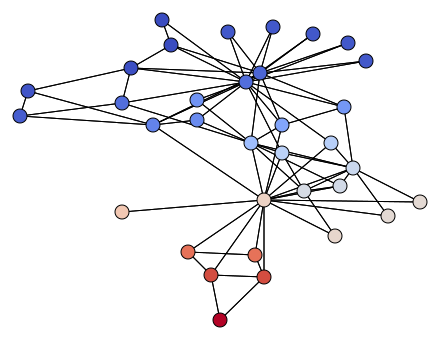

In [48]:
# display an eigenvector
image = visualize_graph(adjacency, position, scores=eigenvectors[:, 0])
SVG(image)

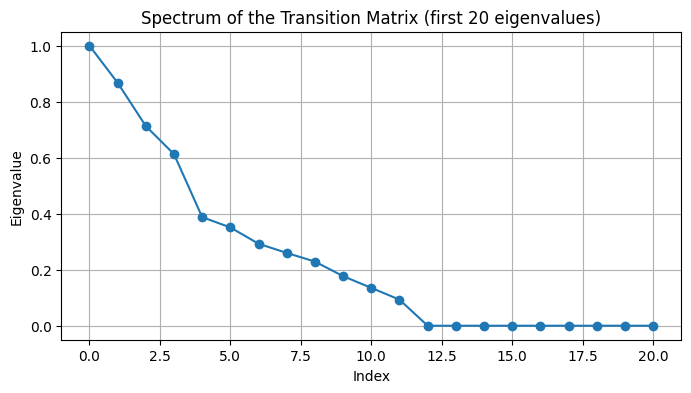

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(eigenvalues, 'o-')
plt.title("Spectrum of the Transition Matrix (first 20 eigenvalues)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

It seems that the optimal amount of clusters for the graph is 4, due to the big gap between the eigenvalue of the 4th node in comparison with the 5th node's eigenvalue. However, since the last 2 eigenvalues (3th and 4th) are way lower than the 2nd one, the optimal clustering could be the one with 2 clusters.

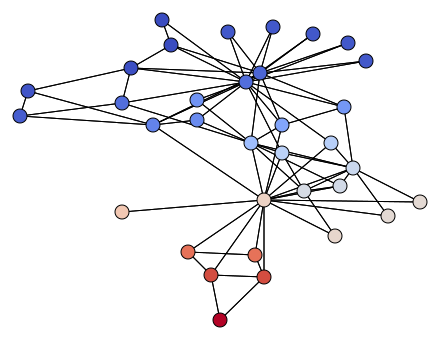

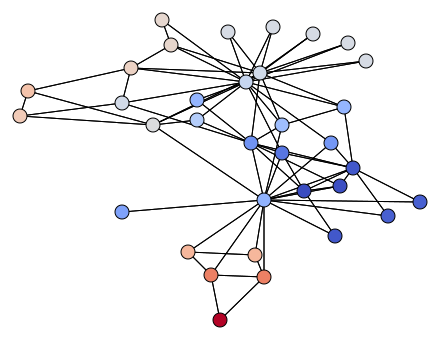

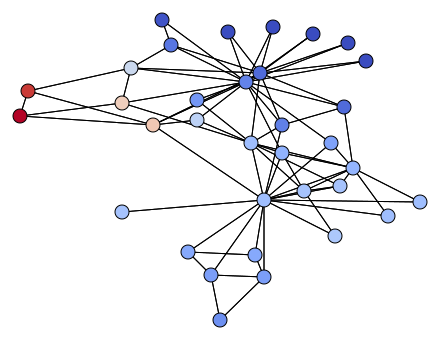

In [50]:
for i in range(0, 3):
    image = visualize_graph(adjacency, position, scores=eigenvectors[:, i])
    display(SVG(image))

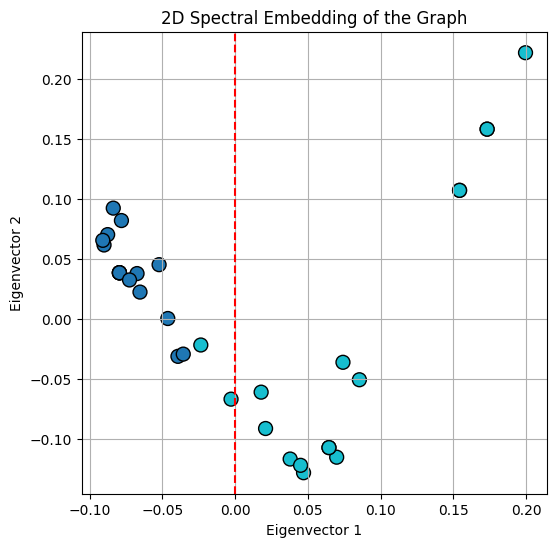

In [51]:
plt.figure(figsize=(6, 6))
plt.scatter(eigenvectors[:, 0],eigenvectors[:, 1], c=labels_true, cmap='tab10', s=100, edgecolor='k')
plt.axvline(x=0, color='red', linestyle='--', label='x = 0')
plt.title("2D Spectral Embedding of the Graph")
plt.xlabel("Eigenvector 1")
plt.ylabel("Eigenvector 2")
plt.grid(True)
plt.show()

In [52]:
from sklearn.metrics import adjusted_rand_score

predicted_labels = (eigenvectors[:, 0] > 0).astype(int)

ari = adjusted_rand_score(labels_true, predicted_labels)
print(f"Adjusted Rand Index: {ari:.2f}")

accuracy = np.mean(predicted_labels == labels_true)

if(accuracy<0.5):
  accuracy=1-accuracy

print(f"\nAccuracy based on the thresholding of the 1st non-trivial eigenvector: {accuracy:.2f}")

Adjusted Rand Index: 0.77

Accuracy based on the thresholding of the 1st non-trivial eigenvector: 0.94



Predicted graph based on spectral embedding:


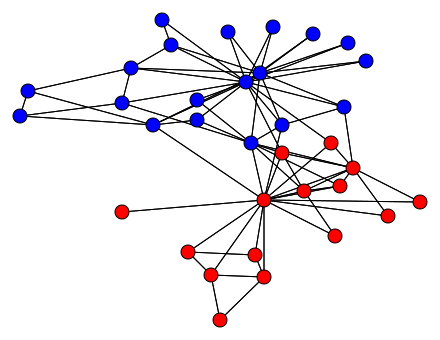


Original graph:


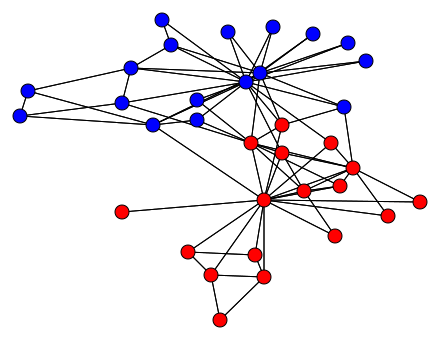

In [53]:
print("\nPredicted graph based on spectral embedding:")
svg = visualize_graph(adjacency, position, labels=predicted_labels)
display(SVG(svg))

print("\nOriginal graph:")
svg = visualize_graph(adjacency, position, labels=labels_true)
display(SVG(svg))

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [54]:
dataset = openflights

In [55]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

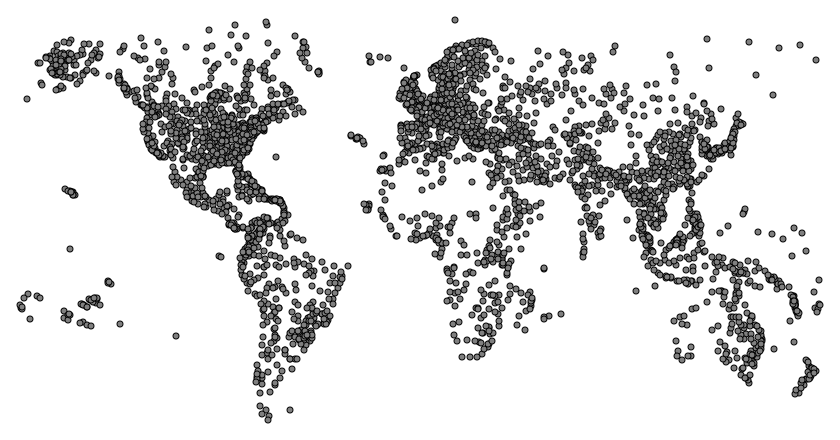

In [56]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space. You can use ``scikit-learn``for k-means.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. <br>**Hint:** Compute the Euclidean norm of the centroid of each cluster in the embedding space.

In [57]:
spectral = Spectral(20, normalized=True)

In [58]:
embedding = spectral.fit_transform(adjacency)

In [59]:
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=8, random_state=0).fit(embedding)
labels_1 = kmeans_1.labels_

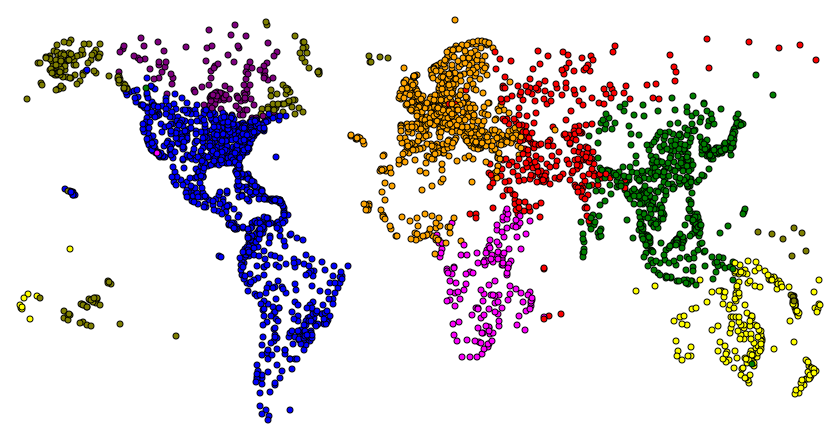

In [60]:
svg = visualize_graph(adjacency, position, labels=labels_1, width=800, height=400, node_size=3, display_edges=False)
SVG(svg)

In [61]:
spectral_2 = Spectral(n_components=20, normalized=False)
embedding_2 = spectral_2.fit_transform(adjacency)

kmeans_2 = KMeans(n_clusters=8, random_state=0).fit(embedding_2)
labels_2 = kmeans_2.labels_

In [62]:
centroids = kmeans_2.cluster_centers_
centroid_norms = np.linalg.norm(centroids, axis=1)

In [63]:
print("Centroid norm without normalization for each cluster:")
for i, norm in enumerate(centroid_norms):
    print(f"  Cluster {i+1}: {norm:.4f}")

Centroid norm without normalization for each cluster:
  Cluster 1: 0.0021
  Cluster 2: 0.1714
  Cluster 3: 0.2717
  Cluster 4: 0.0830
  Cluster 5: 0.1009
  Cluster 6: 0.1545
  Cluster 7: 0.2328
  Cluster 8: 0.0825


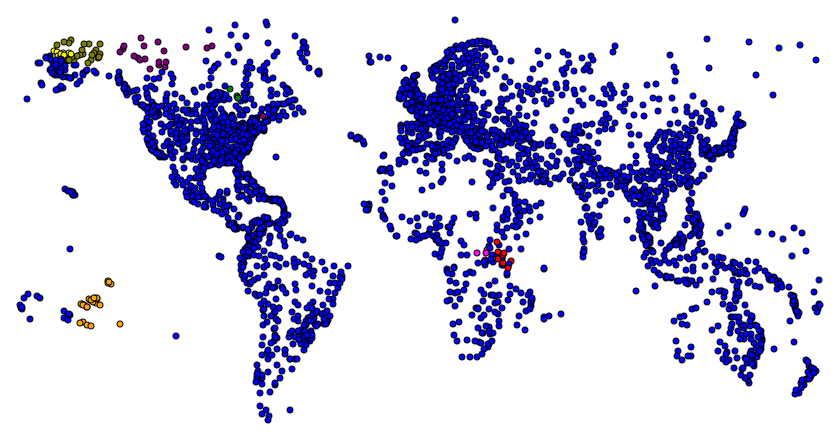

In [64]:
svg = visualize_graph(adjacency, position, labels=labels_2, width=800, height=400, node_size=3, display_edges=False)
SVG(svg)

When comparing the two visualizations, we can see that using a normalized embedding (normalized=True) leads to eight clearly defined and spatially coherent clusters. This happens because k-means, when applied to vectors on the unit sphere, clusters primarily based on direction — and in this context, the direction captures the position of each airport within its airspace community.

In contrast, the non-normalized embedding (normalized=False) results in one dominant cluster (shown in blue on the second map) that includes most of the airports, along with a few small clusters (in red, yellow, green, etc.) containing only a handful of nodes. This outcome is due to the fact that without normalization, k-means is influenced more by the magnitude (norm) of the vectors. As a result, most points—those with smaller magnitudes and close to the origin—are lumped into one cluster, while only the few nodes with large norms get separated into distinct groups.

## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in the embedding space in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we project the vectors on the unit sphere.

In [65]:
spectral = Spectral(20, normalized=True)

## Wikipedia Vitals

In [66]:
dataset = wikivitals

In [67]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the spectral embedding of the graph of links in dimension 20.

* List the 20 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space. Compare with the top articles obtained with Personalized PageRank.
* Display the 3D-plot of each of the 11 labels in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the centroid of the corresponding articles, with a size proportional to the number of articles. Use ``plotly`` for an interactive plot. Interpret the results.
* Display the dendrogram of the hierarchical clustering of the top-100 articles on **Arts** (in terms of Personalized PageRank). You might use the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space. Comment the results.

In [68]:
import plotly.express as px

In [69]:
from scipy.cluster.hierarchy import linkage,dendrogram
from IPython.display import HTML, display
from sklearn.metrics.pairwise import cosine_similarity


In [70]:
embedding = spectral.fit_transform(adjacency)
targ = 'Vincent van Gogh'
vangogh_indx = int(np.where(names == targ)[0][0])

In [71]:
cos_simty = cosine_similarity(embedding[vangogh_indx:vangogh_indx+1], embedding)[0]
top20_cos_indx = np.argsort(-cos_simty)[1:11]

In [72]:
print("Top 20 articles closest to 'Vincent Van Gogh' based on cosine similarity:")
for i in top20_cos_indx:
    print(f"{names[i]:<40} {cos_simty[i]:.4f}")

Top 20 articles closest to 'Vincent Van Gogh' based on cosine similarity:
Georges Seurat                           0.9942
Paul Cézanne                             0.9939
Paul Gauguin                             0.9938
Henri de Toulouse-Lautrec                0.9923
Franz Marc                               0.9913
Post-Impressionism                       0.9906
Edvard Munch                             0.9894
Henri Rousseau                           0.9890
Musée National d'Art Moderne             0.9884
Performance art                          0.9864


In [74]:
personal = np.zeros(len(names))
personal[vangogh_indx] = 1
pr = PageRank(0.85)
pr.fit(adjacency, personal)
scores_pr = pr.scores_
top20_pr_idx = np.argsort(-scores_pr)[:20]
print("Top 20 by Personalized PageRank:")
for i in top20_pr_idx:
    print(f"{names[i]:<40} {scores_pr[i]:.4f}")

Top 20 by Personalized PageRank:
Vincent van Gogh                         0.1516
World War I                              0.0038
Metropolitan Museum of Art               0.0037
Impressionism                            0.0037
Pablo Picasso                            0.0035
Modernism                                0.0035
Paul Cézanne                             0.0034
Cubism                                   0.0034
National Gallery of Art                  0.0033
Post-Impressionism                       0.0033
Claude Monet                             0.0033
Paul Gauguin                             0.0033
Symbolism (arts)                         0.0033
Modern art                               0.0033
Museum of Modern Art                     0.0033
Art Nouveau                              0.0033
Expressionism                            0.0032
BBC                                      0.0032
Wassily Kandinsky                        0.0032
Henri Matisse                            0.0031


In [75]:
personal = np.zeros(len(names))
personal[vangogh_indx] = 1
pr = PageRank(0.85)
pr.fit(adjacency, personal)
scores_pr = pr.scores_
top20_pr_indx = np.argsort(-scores_pr)[:21]
print("Top 20 articles closest to 'Vincent Van Gogh' based on personalized PageRank (Excluding the same article):\n")
for i in range(1,21):
    print(f"Top {i}: {names[top20_pr_indx[i]]:<40} {scores_pr[top20_pr_indx[i]]:.4f}")

Top 20 articles closest to 'Vincent Van Gogh' based on personalized PageRank (Excluding the same article):

Top 1: World War I                              0.0038
Top 2: Metropolitan Museum of Art               0.0037
Top 3: Impressionism                            0.0037
Top 4: Pablo Picasso                            0.0035
Top 5: Modernism                                0.0035
Top 6: Paul Cézanne                             0.0034
Top 7: Cubism                                   0.0034
Top 8: National Gallery of Art                  0.0033
Top 9: Post-Impressionism                       0.0033
Top 10: Claude Monet                             0.0033
Top 11: Paul Gauguin                             0.0033
Top 12: Symbolism (arts)                         0.0033
Top 13: Modern art                               0.0033
Top 14: Museum of Modern Art                     0.0033
Top 15: Art Nouveau                              0.0033
Top 16: Expressionism                            0.0032
Top 1

In [76]:
rows = []
for lab in np.unique(labels):
    mask = labels == lab
    centroid = embedding[mask, :3].mean(axis=0)
    count = mask.sum()
    rows.append({'Label': names_labels[lab],'x': centroid[0], 'y': centroid[1], 'z': centroid[2], 'Count': count})
df = pd.DataFrame(rows)

In [77]:
fig = px.scatter_3d(df, x='x', y='y', z='z', size='Count', color='Label', hover_name='Label', size_max=40, title='Embedding label centroids in 3 dimensions')
fig.update_layout(scene=dict(xaxis_title='Eigenvector 1', yaxis_title='Eigenvector 2', zaxis_title='Eigenvector 3',))
html_str = fig.to_html(include_plotlyjs='cdn')
display(HTML(html_str))

In the spectral embedding, cosine similarity reflects how similar the angles between vectors are, meaning that two items are considered close if they point in roughly the same direction in the latent space. For Vincent van Gogh, this results in neighbors that are primarily other artists from the same era, associated artistic movements, or important museums — effectively capturing the stylistic, historical, and cultural context surrounding his work.

In contrast, Personalized PageRank highlights global network proximity, emphasizing how easily one can reach other nodes from Van Gogh through random walks. This brings in a broader mix — including notable artists like Cézanne, Picasso, and Gauguin — but also connects to major institutions and historical events, producing a more general and less focused neighborhood.

The tag cloud visually separates these thematic groups, while the spectral dimensions EV1, EV2, and EV3 help reveal distinct conceptual regions in the embedding space, where strong semantic patterns emerge. Moreover, the size of each dot indicates the density of items in a given category, with areas like People and Arts standing out due to their larger volume.

In [78]:
label_arts = np.where(names_labels == "Arts")[0][0]
mask_arts = labels == label_arts
idx_arts = np.where(mask_arts)[0]

In [79]:
pr = PageRank(0.85)
pr.fit(adjacency)
scores = pr.scores_

In [80]:
arts_scores = scores[mask_arts]
top_100_arts_idx = idx_arts[np.argsort(-arts_scores)[:100]]

embedding_top100 = embedding[top_100_arts_idx]

In [81]:
Z = linkage(embedding_top100, method='ward')
labels_top100 = names[top_100_arts_idx]

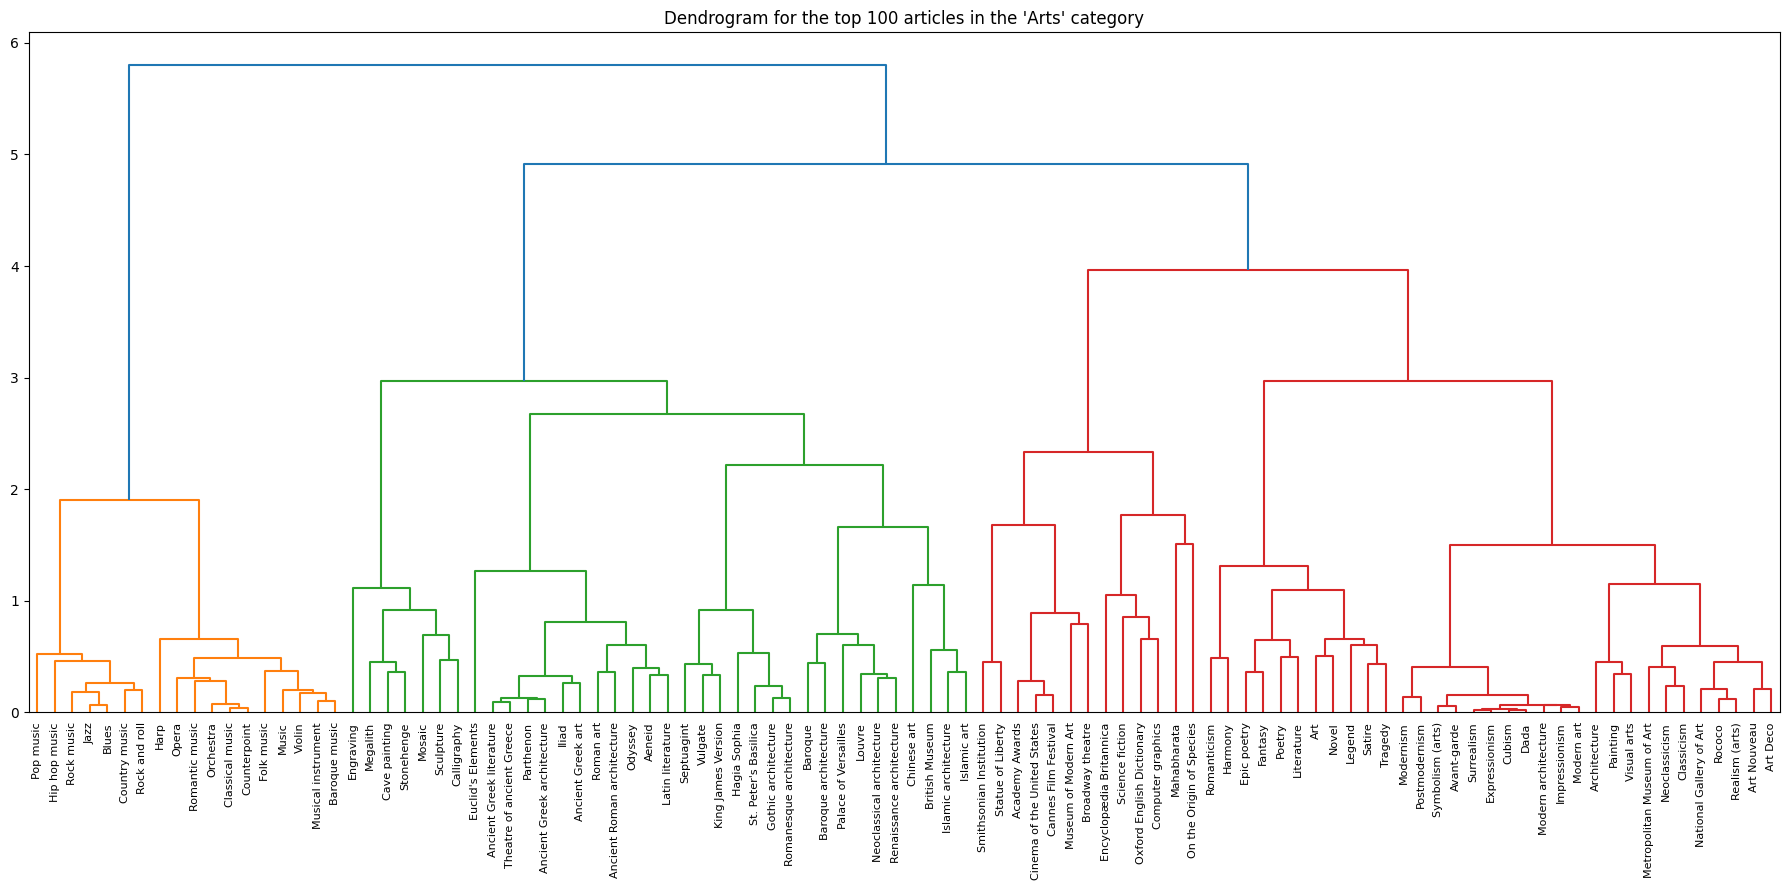

In [82]:
plt.figure(figsize=(18, 9))
dendrogram(Z, labels=labels_top100, leaf_rotation=90, leaf_font_size=8)
plt.title("Dendrogram for the top 100 articles in the 'Arts' category")
plt.tight_layout()
plt.show()

The dendrogram uncovers a layered organization that aligns well with how we naturally think about the subdivisions within the Arts. At the top level, we see three to four broad groupings emerge — such as popular music and its associated styles, classical and manual arts, institutions and media references (like cinema), and modern artistic movements and figures. As we move down the hierarchy, more detailed groupings appear. For instance, in the music branch, high-level genres like pop/rock and jazz/blues are clearly distinguished before breaking down into more specific styles. Similarly, within the visual arts, fields like architecture and engineering — which are more static and technical — form their own branch. The clustering of movements mirrors historical progression and stylistic relationships quite closely.

If we choose to cut the dendrogram at approximately height 2.5, we end up with 4 to 5 well-defined clusters: Popular Music, Technical and Classical Arts, Cultural Institutions and Media, and Modern Artists and Movements.

Overall, the Ward-based dendrogram does an excellent job capturing the main thematic areas within the Arts. It reveals major categories like musical styles, traditional techniques, platforms of dissemination, and modern artistic trends. As the hierarchy is sliced at finer levels, increasingly detailed and historically coherent subfields emerge — effectively tracing the structure of artistic development and practice.

## To do

* Repeat the same experiments on the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

In [83]:
from scipy.sparse import diags, bmat

n_articles, n_words = biadjacency.shape

A_bip = bmat([[None, biadjacency], [biadjacency.T, None]], format='csr')

In [84]:
spectral_bip = Spectral(n_components=20, decomposition='rw', normalized=True)
spectral_bip.fit(A_bip)
emb_all = spectral_bip.eigenvectors_

In [85]:
emb_articles = emb_all[:n_articles, :]
emb_words = emb_all[n_articles:, :]

target = 'painting'
idx_word = int(np.where(words == target)[0][0])
vec_paint = emb_words[idx_word].reshape(1, -1)

In [86]:
sim_articles = cosine_similarity(vec_paint, emb_articles)[0]
sim_words = cosine_similarity(vec_paint, emb_words)[0]

In [87]:
top10_art = np.argsort(-sim_articles)[:10]
print("\nTop 10 articles closest to the 'painting' word based on the embedding space:")
k=0
for i in top10_art:
    k=k+1
    print(f"Top {k}: {names[i]:<40} {sim_articles[i]:.3f}")


Top 10 articles closest to the 'painting' word based on the embedding space:
Top 1: Les Demoiselles d'Avignon                0.952
Top 2: Hieronymus Bosch                         0.947
Top 3: Rembrandt                                0.944
Top 4: Modern art                               0.941
Top 5: Peter Paul Rubens                        0.939
Top 6: Gian Lorenzo Bernini                     0.936
Top 7: Symbolism (arts)                         0.932
Top 8: Constantin Brâncuși                      0.929
Top 9: Pieter Bruegel the Elder                 0.929
Top 10: Johannes Vermeer                         0.926


In [88]:
order_words = np.argsort(-sim_words)
top10_word = [i for i in order_words if i != idx_word][:10]
print("\nTop 10 words closest to 'painting' word based on the embedding space:")
k=0
for i in top10_word:
    k=k+1
    print(f"Top {k}: {words[i]:<20} {sim_words[i]:.3f}")



Top 10 words closest to 'painting' word based on the embedding space:
Top 1: Rembrandt            0.969
Top 2: Netherlandish        0.969
Top 3: Bruegel              0.964
Top 4: Painters             0.959
Top 5: Demoiselles          0.959
Top 6: Rubens               0.959
Top 7: portraiture          0.957
Top 8: draughtsman          0.952
Top 9: Vermeer              0.952
Top 10: Lautrec              0.951


## To do

* Prove that the average cosine similarity between vectors in some set $S$ is equal to the square norm of the centroid of $S$.

$$
S=\{v_1,\ldots,v_n\}
$$
$$
\mu = \frac 1 n \sum_{i=1}^n v_i
$$

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality.
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). Comment the results.

In [89]:
def spectral_rw(adj, k=20):
    sp = Spectral(n_components=k, decomposition='rw', normalized=True)
    return sp.fit_transform(adj)

In [90]:
def avg_cos(mask, emb):
    if mask.sum() == 0:
        return np.nan
    centroid = emb[mask].mean(axis=0, keepdims=True)
    return float((centroid @ centroid.T)[0, 0])

In [91]:
def expected_cos(emb):
    mu = emb.mean(axis=0, keepdims=True)
    return float((mu @ mu.T)[0, 0])

In [92]:
def label_table(emb, lab_vec, lab_names):
    out = []
    for lid, name in enumerate(lab_names):
        m = lab_vec == lid
        out.append((name, avg_cos(m, emb), m.sum()))
    return pd.DataFrame(out, columns=['label', 'avg_cos', 'n'])

In [93]:
def find_label_id(partial, lab_names):
    candidates = [i for i,lab in enumerate(lab_names)
                  if re.search(partial, lab, flags=re.I)]
    if not candidates:
        raise ValueError(f"No label matches '{partial}'")
    return candidates[0]

In [94]:
import re

emb_links = spectral_rw(adjacency)

emb_bip_all = spectral_rw(A_bip)
emb_bip_articles = emb_bip_all[:n_articles]

In [95]:
partial = "mammal"
mamm_id = find_label_id(partial, names_labels_hierarchy)
mask_mammal = labels_hierarchy == mamm_id

In [96]:
mamm_links = avg_cos(mask_mammal, emb_links)
mamm_bip = avg_cos(mask_mammal, emb_bip_articles)
exp_links = expected_cos(emb_links)
exp_bip = expected_cos(emb_bip_articles)

print(f"Mammalia Labels: {names_labels_hierarchy[mamm_id]}")
print(f"Articles in set : {mask_mammal.sum()}")
print(f"Avg cos – Links : {mamm_links:.4f}")
print(f"Avg cos – Bip   : {mamm_bip:.4f}")
print(f"Random exp cos  : {exp_links:.4f} (links)  |  {exp_bip:.4f} (bip)")

Mammalia Labels: Biological and health sciences|||Organisms|||Animals|||Mammals
Articles in set : 6
Avg cos – Links : 0.9864
Avg cos – Bip   : 0.9449
Random exp cos  : 0.0061 (links)  |  0.0069 (bip)


In [97]:
df_links = label_table(emb_links, labels, names_labels).sort_values('avg_cos', ascending=False)
df_bip = label_table(emb_bip_articles, labels, names_labels).sort_values('avg_cos', ascending=False)

print("\nLinks graph:")
print(df_links[['label','avg_cos','n']].to_string(index=False, formatters={'avg_cos':'{:.4f}'.format}))
print("\nBipartite graph:")
print(df_bip[['label','avg_cos','n']].to_string(index=False, formatters={'avg_cos':'{:.4f}'.format}))


Links graph:
                         label avg_cos    n
                   Mathematics  0.6573  300
       Philosophy and religion  0.3985  435
                    Technology  0.3241  746
Biological and health sciences  0.3134 1479
                     Geography  0.2771 1201
                       History  0.2606  680
             Physical sciences  0.2514 1097
                 Everyday life  0.2159  479
   Society and social sciences  0.2003  930
                          Arts  0.1866  673
                        People  0.0870 1991

Bipartite graph:
                         label avg_cos    n
                   Mathematics  0.8385  300
                     Geography  0.5480 1201
       Philosophy and religion  0.4881  435
                    Technology  0.3756  746
                          Arts  0.2899  673
Biological and health sciences  0.2788 1479
                 Everyday life  0.2773  479
             Physical sciences  0.2501 1097
                       History  0.2442  680


In [98]:
df_h_links = label_table(emb_links, labels_hierarchy, names_labels_hierarchy)
df_h_bip = label_table(emb_bip_articles, labels_hierarchy, names_labels_hierarchy)

df_h_links = df_h_links[df_h_links['n'] >= 10]
df_h_bip = df_h_bip[df_h_bip['n'] >= 10]

In [99]:
top10_links = df_h_links.nlargest(10, 'avg_cos')
bot10_links = df_h_links.nsmallest(10, 'avg_cos')

top10_bip = df_h_bip.nlargest(10, 'avg_cos')
bot10_bip = df_h_bip.nsmallest(10, 'avg_cos')

print("\n10 most topical categories (Links graph):")
print(top10_links[['label','avg_cos','n']].to_string(index=False, formatters={'avg_cos':'{:.4f}'.format}))
print("\n10 least topical categories (Links graph):")
print(bot10_links[['label','avg_cos','n']].to_string(index=False, formatters={'avg_cos':'{:.4f}'.format}))


10 most topical categories (Links graph):
                                                                                            label avg_cos  n
                        Physical sciences|||Measurement|||Units of measurement|||Electromagnetism  0.9981 11
               Geography|||Physical geography|||Bodies of water|||Oceans and seas|||Pacific Ocean  0.9937 14
Physical sciences|||Chemistry|||Chemical substances|||Chemical elements|||Chemical element groups  0.9934 10
      Physical sciences|||Chemistry|||Chemical substances|||Chemical elements|||Chemical elements  0.9927 98
                                          People|||Sports figures|||Individual sports|||Athletics  0.9925 13
                        Biological and health sciences|||Anatomy and morphology|||Plant|||General  0.9904 10
                             Physical sciences|||Astronomy|||Astronomical objects|||Notable stars  0.9901 10
                                                  Geography|||Countries|||Africa|||Ce

In [100]:
print("\n10 most topical categories (Bipartite graph):")
print(top10_bip[['label','avg_cos','n']].to_string(index=False, formatters={'avg_cos':'{:.4f}'.format}))
print("\n10 least topical categories (Bipartite graph):")
print(bot10_bip[['label','avg_cos','n']].to_string(index=False, formatters={'avg_cos':'{:.4f}'.format}))


10 most topical categories (Bipartite graph):
                                                                                      label avg_cos  n
                               People|||Sports figures|||Team sports|||Association football  0.9922 14
                       Physical sciences|||Astronomy|||Astronomical objects|||Notable stars  0.9819 10
                                                   Mathematics|||Algebra|||Abstract algebra  0.9807 14
                                                          Mathematics|||Geometry|||Topology  0.9803 10
     People|||Musicians and composers|||Western art music|||Composers|||20th century modern  0.9750 14
                                     Philosophy and religion|||Eastern religions|||Hinduism  0.9745 18
                                Arts|||Modern visual arts|||Filmmaking|||Films|||Drama film  0.9700 10
                                    People|||Musicians and composers|||Popular music|||Rock  0.9624 17
               Everyday li

The average cosine similarity within a group is roughly equal to the squared norm of the centroid vector. When this value is close to 1, it means that most vectors point in nearly the same direction — indicating that the articles in the group use highly similar vocabulary or linking patterns. On the other hand, very low values (around 10−310−3) suggest that there’s little internal coherence.

For instance, the Mammalia category shows extremely high topical coherence: all six articles are closely aligned in terms of both keywords and link structure. Even when evaluated with the bipartite model, which tends to slightly lower these scores, the group still maintains strong cohesion.

In this analysis, mathematics-related articles stand out in both models. This likely reflects the field’s precise and repetitive terminology, which naturally boosts similarity. Conversely, the People category shows the lowest cohesion, likely because it brings together biographies from many different domains. Interestingly, the bipartite graph yields higher similarity values in this case, as it’s more sensitive to subtle textual overlaps.

Compared to the bipartite representation, the standard graph model highlights clusters such as football (soccer), abstract algebra, and topology, each with extremely high average cosine similarity (≥ 0.97). These areas benefit from shared technical language. In contrast, more heterogeneous categories like specific historical structures or history by theme show lower cohesion — though slightly improved under the bipartite model, which picks up on common words not always reflected in linking patterns.

In general, topicality tends to correlate with both the size and focus of a category. Small, specialized groups (typically with fewer than 20 articles) often exhibit very strong internal similarity. Broader or catch-all categories, on the other hand, tend to have more diluted link and text patterns.

Finally, it's worth noting that link-based graphs are highly influenced by shared templates and navigation boxes (who links to whom), while the bipartite model is more reflective of direct lexical overlap. This makes the bipartite model particularly effective for capturing cohesion in fields with dense, consistent terminology.